## Forecast the number of clients using WoodGreen’s mental health and community health services weekly.

#### Import neccessary libraries 

In [ ]:
!{sys.executable} -m pip install statsmodels


In [190]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

#### Load and Inspect columns

In [ ]:
# Define the file path 
file_path = "../../woodgreen-data/WoodGreen_All_Systems.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display basic info
print("Dataset loaded successfully!")
print(f"Total rows: {len(df)}")
print(f"Total columns: {len(df.columns)}")

# Print all column names as a Python list
columns_list = df.columns.tolist()
print("\n--- COLUMN NAMES ---")
for col in columns_list:
    print(col)

In [ ]:
# View a few sample values
print(df['program_name_DC'].head(10))

# Check how many non-null entries exist
print("\nNon-null count:", df['program_name_DC'].notna().sum())

# Get a list of unique program names (to understand what's inside)
unique_programs = df['program_name_DC'].dropna().unique()
print("\nNumber of unique programs:", len(unique_programs))

# Print first few unique names
print("\nSample unique program names:")
print(unique_programs[:37])  # adjust number if you want more


### Filter the dataset by 
- Youth Wellness Center
- Rites of Passage
- Community Connections - Group Activities
- Community Connections - Mentorship
- Intensive Case Management for Youth (ICM)

In [193]:
# Define the relevant programs
mental_health_programs = [
    'Youth Wellness Centre',
    'Rites of Passage',
    'Community Connections - Group Activities',
    'Community Connections - Mentorship',
    'Intensive Case Management for Youth (ICM)'
]

# Filter dataset
df_filtered = df[df['program_name_DC'].isin(mental_health_programs)].copy()

# Check how many records remain
print("Filtered dataset size:", df_filtered.shape)
print("Programs in filtered dataset:", df_filtered['program_name_DC'].unique())


Filtered dataset size: (1209, 188)
Programs in filtered dataset: ['Community Connections - Group Activities' 'Youth Wellness Centre'
 'Community Connections - Mentorship' 'Rites of Passage'
 'Intensive Case Management for Youth (ICM)']


#### Visualize how many clients are registered in each mental/community health program.

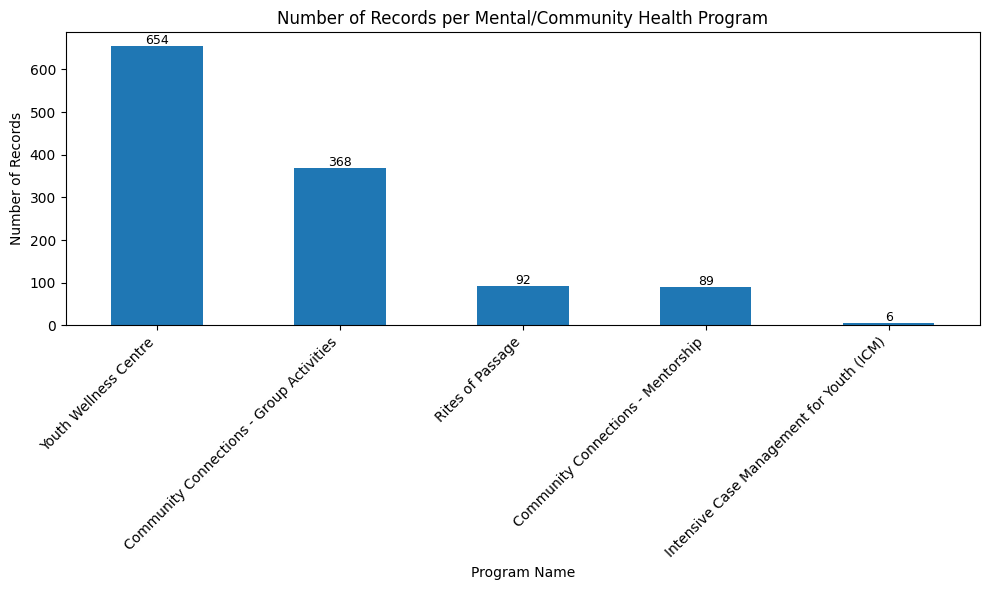

In [194]:
# Count how many records per program
program_counts = df_filtered['program_name_DC'].value_counts()

# Plot bar chart
plt.figure(figsize=(10, 6))
program_counts.plot(kind='bar')

# Add labels and title
plt.title('Number of Records per Mental/Community Health Program')
plt.xlabel('Program Name')
plt.ylabel('Number of Records')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, v in enumerate(program_counts):
    plt.text(i, v + 5, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()


In [195]:
# Filter mental health programs and create a copy
df_mental = df[df['program_name_DC'].isin(mental_health_programs)].copy()

# Try multiple possible date columns
date_columns = ['Client Intake Date_AC', 'program_startdate_DC', 'Start Date_AC', 'Service Start Date_CC']

# Find which column has valid dates
for col in date_columns:
    df_mental['intake_date'] = pd.to_datetime(df_mental[col], errors='coerce')
    valid_count = df_mental['intake_date'].notna().sum()
    print(f"{col}: {valid_count} valid dates")

# Choose the column with the most valid dates
df_mental['intake_date'] = pd.to_datetime(df_mental['program_startdate_DC'], errors='coerce')  # Example

# Inspect
print("Number of records with valid intake dates:", df_mental['intake_date'].notna().sum())
print("Earliest intake date:", df_mental['intake_date'].min())
print("Latest intake date:", df_mental['intake_date'].max())
print("\nRecord count per year:")
print(df_mental['intake_date'].dt.year.value_counts().sort_index())


Client Intake Date_AC: 0 valid dates
program_startdate_DC: 1209 valid dates
Start Date_AC: 0 valid dates
Service Start Date_CC: 0 valid dates
Number of records with valid intake dates: 1209
Earliest intake date: 2024-07-15 00:00:00
Latest intake date: 2025-10-17 00:00:00

Record count per year:
intake_date
2024    585
2025    624
Name: count, dtype: int64


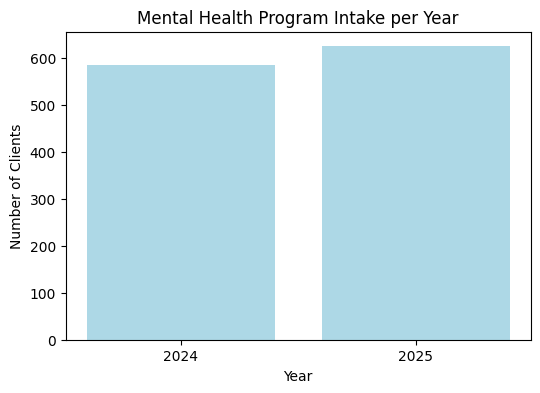

In [196]:
# Count per year
yearly_counts = df_mental['intake_date'].dt.year.value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
plt.bar(yearly_counts.index.astype(str), yearly_counts.values, color='lightblue')
plt.title('Mental Health Program Intake per Year')
plt.xlabel('Year')
plt.ylabel('Number of Clients')
plt.show()

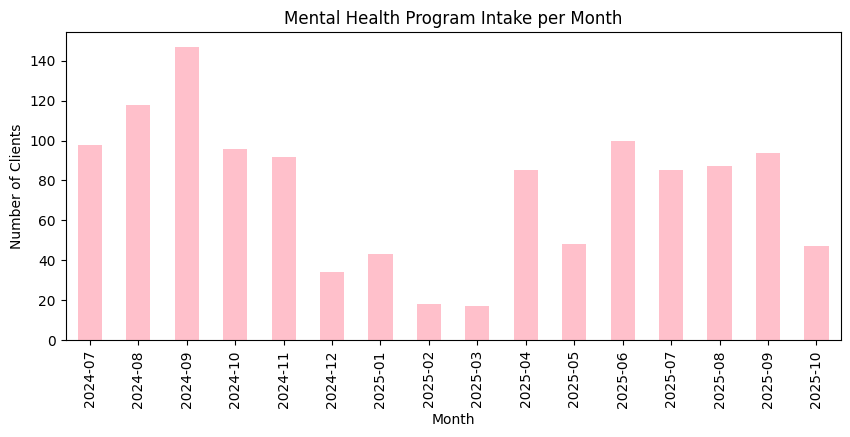

In [197]:
monthly_counts = df_mental['intake_date'].dt.to_period('M').value_counts().sort_index()

plt.figure(figsize=(10,4))
monthly_counts.plot(kind='bar', color='pink')
plt.title('Mental Health Program Intake per Month')
plt.xlabel('Month')
plt.ylabel('Number of Clients')
plt.show()


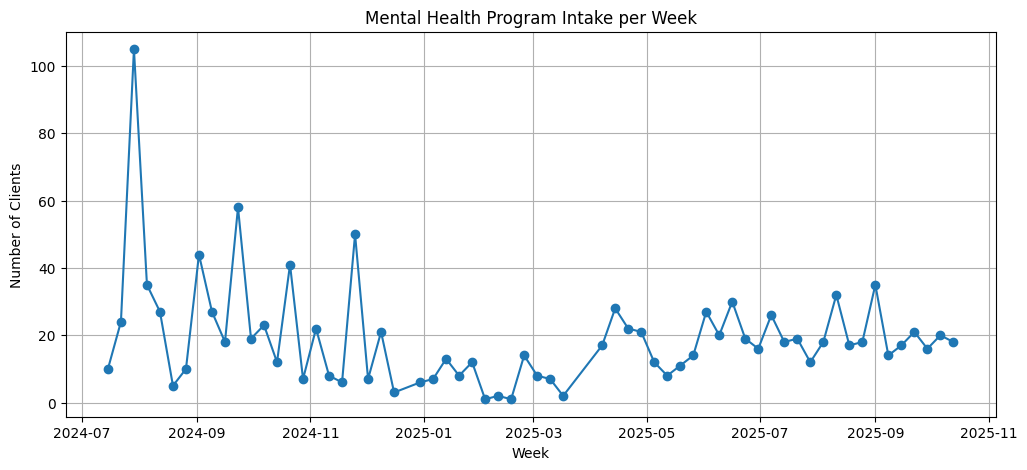

In [198]:
# Aggregate weekly
weekly_counts = df_mental['intake_date'].dt.to_period('W').value_counts().sort_index()

# Convert PeriodIndex to datetime for plotting
weekly_counts.index = weekly_counts.index.to_timestamp()

# Plot weekly trend
plt.figure(figsize=(12,5))
plt.plot(weekly_counts.index, weekly_counts.values, marker='o', linestyle='-')
plt.title('Mental Health Program Intake per Week')
plt.xlabel('Week')
plt.ylabel('Number of Clients')
plt.grid(True)
plt.show()


#### Toronto weather (2024 - 2025)

In [199]:
weather_2024_df = pd.read_csv('../data/toronto-weather/weather-2024-data.csv')
weather_2025_df = pd.read_csv('../data/toronto-weather/weather-2025-data.csv')

In [200]:
def prepare_weekly_weather(df):
    # Convert Date/Time to datetime
    df['Date/Time'] = pd.to_datetime(df['Date/Time'], errors='coerce')
    
    # Keep relevant columns
    df = df[['Date/Time', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
             'Total Rain (mm)', 'Total Snow (cm)']].copy()
    
    # Add week number and year
    df['Year'] = df['Date/Time'].dt.year
    df['Week'] = df['Date/Time'].dt.isocalendar().week
    
    # Aggregate by week
    weekly_df = df.groupby(['Year', 'Week']).agg({
        'Max Temp (°C)': 'mean',
        'Min Temp (°C)': 'mean',
        'Mean Temp (°C)': 'mean',
        'Total Rain (mm)': 'sum',
        'Total Snow (cm)': 'sum'
    }).reset_index()
    
    return weekly_df

# Prepare weekly weather
weekly_weather_2024 = prepare_weekly_weather(weather_2024_df)
weekly_weather_2025 = prepare_weekly_weather(weather_2025_df)

# Combine 2024 and 2025
weekly_weather_all = pd.concat([weekly_weather_2024, weekly_weather_2025], ignore_index=True)

print(weekly_weather_all.tail(10))


     Year  Week  Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  \
94   2025    43      13.014286       3.828571        8.428571   
95   2025    44      10.600000       2.466667        6.566667   
96   2025    45            NaN            NaN             NaN   
97   2025    46            NaN            NaN             NaN   
98   2025    47            NaN            NaN             NaN   
99   2025    48            NaN            NaN             NaN   
100  2025    49            NaN            NaN             NaN   
101  2025    50            NaN            NaN             NaN   
102  2025    51            NaN            NaN             NaN   
103  2025    52            NaN            NaN             NaN   

     Total Rain (mm)  Total Snow (cm)  
94               4.1              0.0  
95               0.0              0.0  
96               0.0              0.0  
97               0.0              0.0  
98               0.0              0.0  
99               0.0              0.0  
100 

In [201]:
# --- For mental health weekly data ---
df_mental_weekly = weekly_counts.reset_index()
df_mental_weekly.columns = ['week_start', 'client_count']

# Extract Year and Week number from week_start
df_mental_weekly['Year'] = df_mental_weekly['week_start'].dt.year
df_mental_weekly['Week'] = df_mental_weekly['week_start'].dt.isocalendar().week

# --- For weather weekly data ---
# Create week_start column for weekly_weather_all
weekly_weather_all['week_start'] = pd.to_datetime(
    weekly_weather_all['Year'].astype(str) + '-W' + 
    weekly_weather_all['Week'].astype(str) + '-1', 
    format='%Y-W%W-%w'
)

# Filter weather to start from July 2024 (week 27)
weekly_weather_filtered = weekly_weather_all[
    (weekly_weather_all['Year'] > 2024) |
    ((weekly_weather_all['Year'] == 2024) & (weekly_weather_all['Week'] >= 27))
].reset_index(drop=True)


merged_df = pd.merge(df_mental_weekly, weekly_weather_filtered, how='left', on=['Year', 'Week'])

print(merged_df.head())



  week_start_x  client_count  Year  Week  Max Temp (°C)  Min Temp (°C)  \
0   2024-07-15            10  2024    29      26.714286      16.671429   
1   2024-07-22            24  2024    30      27.057143      16.428571   
2   2024-07-29           105  2024    31      29.485714      20.871429   
3   2024-08-05            35  2024    32      24.528571      15.642857   
4   2024-08-12            27  2024    33      26.414286      16.014286   

   Mean Temp (°C)  Total Rain (mm)  Total Snow (cm) week_start_y  
0       21.714286            122.9              0.0   2024-07-15  
1       21.771429             22.6              0.0   2024-07-22  
2       25.200000              8.7              0.0   2024-07-29  
3       20.100000             13.9              0.0   2024-08-05  
4       21.242857            152.7              0.0   2024-08-12  


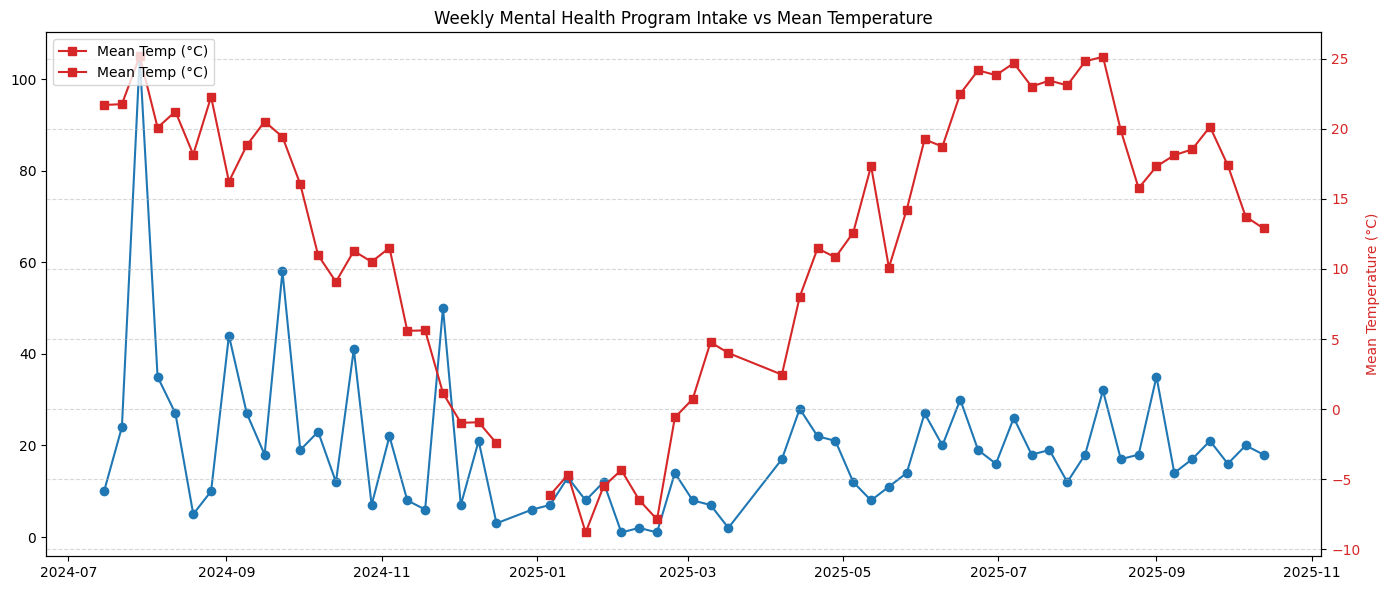

In [202]:
plt.figure(figsize=(14,6))

plt.plot(merged_df['week_start_x'], merged_df['client_count'], marker='o', color='tab:blue', label='Client Count')

ax2 = plt.gca().twinx()
ax2.plot(merged_df['week_start_x'], merged_df['Mean Temp (°C)'], marker='s', color='tab:red', label='Mean Temp (°C)')

plt.title('Weekly Mental Health Program Intake vs Mean Temperature')
plt.xlabel('Week Start')
plt.ylabel('Number of Clients', color='tab:blue')
ax2.set_ylabel('Mean Temperature (°C)', color='tab:red')

plt.gca().tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.grid(True, linestyle='--', alpha=0.5)
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()


#### Prepare the dataset

In [203]:
# Ensure week_start is datetime and sort
merged_df['week_start_x'] = pd.to_datetime(merged_df['week_start_x'])
merged_df = merged_df.sort_values('week_start_x')

# Select only client counts
weekly_series = merged_df.set_index('week_start_x')['client_count']

# Split train/test
train = weekly_series['2024-07-01':'2025-07-31']
test = weekly_series['2025-08-01':'2025-10-15']

#### Fit an ARIMA Model

In [204]:
# Fit ARIMA
model = ARIMA(train, order=(1,1,1))  # simple starting point
model_fit = model.fit()

# Forecast for test period
forecast = model_fit.forecast(steps=len(test))


/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results w

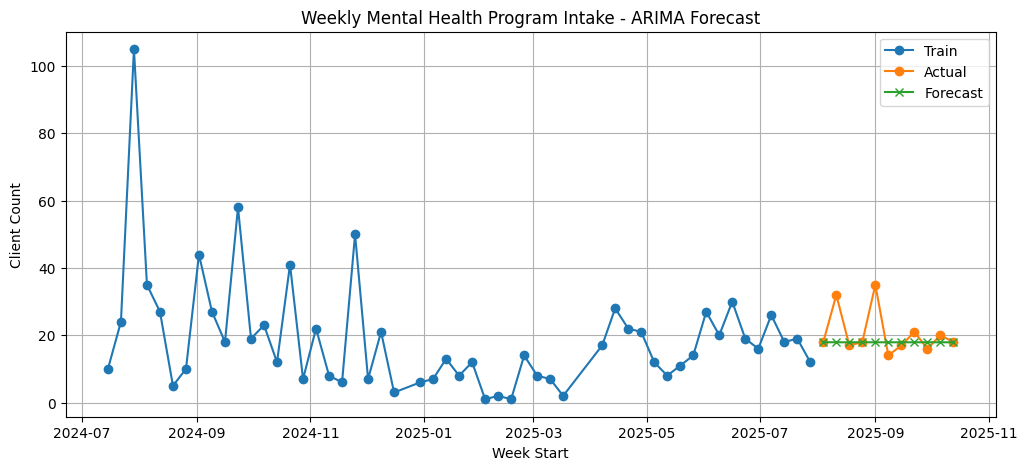

In [205]:

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train', marker='o')
plt.plot(test.index, test, label='Actual', marker='o')
plt.plot(test.index, forecast, label='Forecast', marker='x')
plt.title('Weekly Mental Health Program Intake - ARIMA Forecast')
plt.xlabel('Week Start')
plt.ylabel('Client Count')
plt.legend()
plt.grid(True)
plt.show()


In [206]:

mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')


MAE: 4.02
RMSE: 6.91


/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
!{sys.executable} -m pip install prophet


In [208]:
print(merged_df.columns)


Index(['week_start_x', 'client_count', 'Year', 'Week', 'Max Temp (°C)',
       'Min Temp (°C)', 'Mean Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)',
       'week_start_y'],
      dtype='object')


14:22:04 - cmdstanpy - INFO - Chain [1] start processing
14:22:04 - cmdstanpy - INFO - Chain [1] done processing


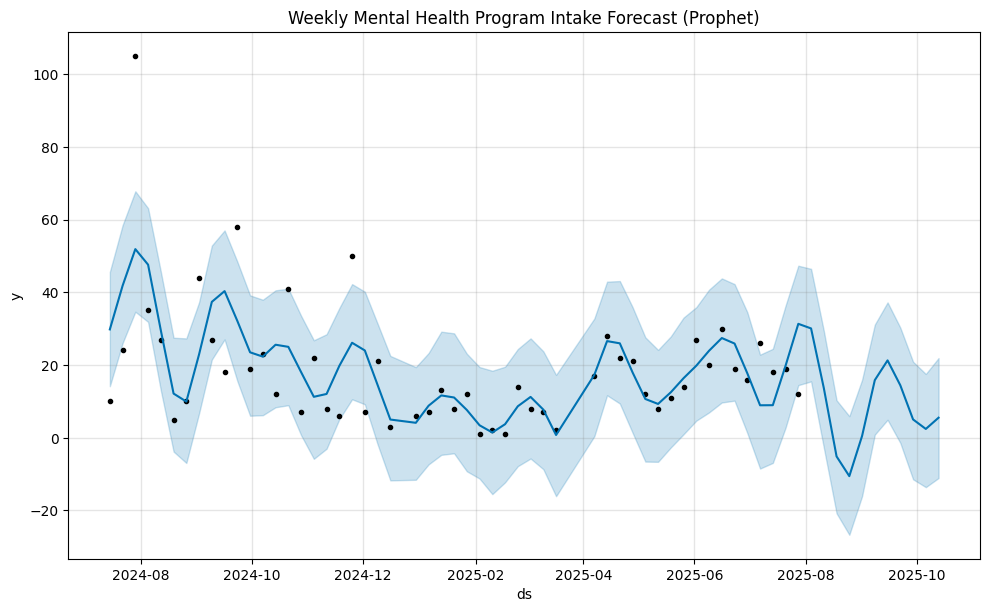

In [209]:
from prophet import Prophet

# Make a copy
merged_df_prophet = merged_df.copy()

# Ensure a consistent week_start column exists (handle different column names)
if 'week_start_x' in merged_df_prophet.columns:
	merged_df_prophet['week_start'] = merged_df_prophet['week_start_x']
elif 'week_start_y' in merged_df_prophet.columns and 'week_start' not in merged_df_prophet.columns:
	merged_df_prophet['week_start'] = merged_df_prophet['week_start_y']

# Prepare ds and y for Prophet (ds must exist to avoid KeyError)
merged_df_prophet['ds'] = pd.to_datetime(merged_df_prophet['week_start'])
merged_df_prophet['y'] = merged_df_prophet['client_count']

# DataFrame for Prophet
df_prophet = merged_df_prophet[['ds', 'y']].copy()

# Optional: inspect
df_prophet.head()

# Train-test split using df_prophet (which has ds)
train = df_prophet[df_prophet['ds'] < pd.to_datetime('2025-08-01')].copy()
test = df_prophet[df_prophet['ds'] >= pd.to_datetime('2025-08-01')].copy()

# Fit model
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.fit(train)

# Forecast
# Use weekly frequency aligned to Mondays to match week_start values (adjust if needed)
future = model.make_future_dataframe(periods=len(test), freq='W-MON')
forecast = model.predict(future)

# Plot
fig = model.plot(forecast)
plt.title("Weekly Mental Health Program Intake Forecast (Prophet)")
plt.show()


In [210]:
# Prophet's forecast contains 'yhat', 'yhat_lower', 'yhat_upper'
# Align forecast with the test set
# Only take the forecasted values corresponding to the test period
forecast_test = forecast[forecast['ds'] >= pd.to_datetime('2025-08-01')].copy()

# Ensure lengths match
if len(forecast_test) != len(test):
    print("Warning: forecast and test lengths do not match!")
    
# Extract predicted values
y_pred = forecast_test['yhat'].values
y_true = test['y'].values

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Forecast Evaluation Metrics:")
print(f"MAE  : {mae:.2f}")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")

Forecast Evaluation Metrics:
MAE  : 15.40
MSE  : 330.09
RMSE : 18.17


Training set shape: (51, 3)
Test set shape: (11, 3)

Missing values in training set:
week_start_x      0
client_count      0
Mean Temp (°C)    0
dtype: int64

Missing values in test set:
week_start_x      0
client_count      0
Mean Temp (°C)    0
dtype: int64


/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

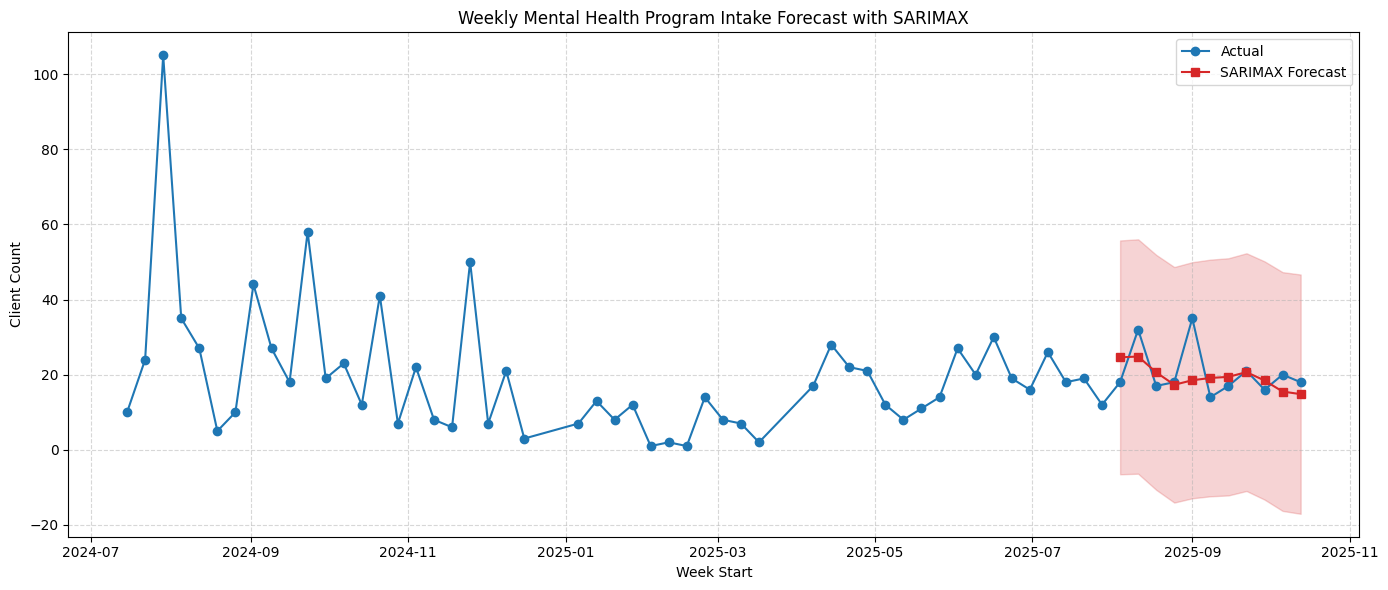


Model Performance:
MAE: 4.78
RMSE: 6.39


In [215]:
# --- Prepare dataset ---
df_sarimax = merged_df[['week_start_x', 'client_count', 'Mean Temp (°C)']].copy()
df_sarimax = df_sarimax.dropna()

# Train-test split
train = df_sarimax[df_sarimax['week_start_x'] < '2025-08-01'].copy()
test  = df_sarimax[df_sarimax['week_start_x'] >= '2025-08-01'].copy()

# Define endogenous (y) and exogenous (X) variables
y_train = train['client_count']
X_train = train[['Mean Temp (°C)']]
y_test  = test['client_count']
X_test  = test[['Mean Temp (°C)']]

# Verify no missing values
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")
print("\nMissing values in training set:")
print(train.isnull().sum())
print("\nMissing values in test set:")
print(test.isnull().sum())

# --- Fit SARIMAX model ---
model = SARIMAX(y_train, exog=X_train, order=(1,0,1), seasonal_order=(0,0,0,0))
results = model.fit(disp=False)  # You were missing this line!

# --- Generate forecast ---
# Get forecast for the test period
forecast_obj = results.get_forecast(steps=len(test), exog=X_test)
forecast = forecast_obj.predicted_mean  # Extract just the predicted values
forecast_ci = forecast_obj.conf_int()   # Get confidence intervals if needed

# --- Plot ---
plt.figure(figsize=(14,6))
plt.plot(df_sarimax['week_start_x'], df_sarimax['client_count'], 
         marker='o', label='Actual', color='tab:blue')
plt.plot(test['week_start_x'], forecast, 
         marker='s', label='SARIMAX Forecast', color='tab:red')

# Optional: Add confidence interval
plt.fill_between(test['week_start_x'], 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='tab:red', alpha=0.2)

plt.xlabel('Week Start')
plt.ylabel('Client Count')
plt.title('Weekly Mental Health Program Intake Forecast with SARIMAX')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Evaluation metrics ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))
print(f"\nModel Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

In [213]:
!{sys.executable} -m pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.20.0-cp39-cp39-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.0-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-2.0.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached grpcio-1.76.0-cp39-cp39-macosx_11_0_universal2.whl.metadata (3.7 kB)
  Using cached tensorboar

/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Total data points: 62
Training set: 51 weeks
Test set: 11 weeks

Training sequences shape: (47, 4, 2)
Test sequences shape: (7, 4, 2)

LSTM MODEL ARCHITECTURE


/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4, 50)          │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,101 (125.39 KB)

 Trainable params: 32,101 (125.39 KB)

 Non-trainable params: 0 (0.00 B)


TRAINING MODEL...
Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0381 - mae: 0.1354 - val_loss: 0.0218 - val_mae: 0.1377
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0307 - mae: 0.1197 - val_loss: 0.0127 - val_mae: 0.0997
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0254 - mae: 0.1056 - val_loss: 0.0057 - val_mae: 0.0594
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137 - mae: 0.0825 - val_loss: 0.0028 - val_mae: 0.0436
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0157 - mae: 0.0916 - val_loss: 0.0032 - val_mae: 0.0510
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0186 - mae: 0.1009 - val_loss: 0.0039 - val_mae: 0.0560
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0162 - mae: 0.0972 - val_loss: 0.0034 - val_mae: 0.0529
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0165 - mae: 0.0988 - val_loss: 0.0030 - val_mae: 0.0487
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0

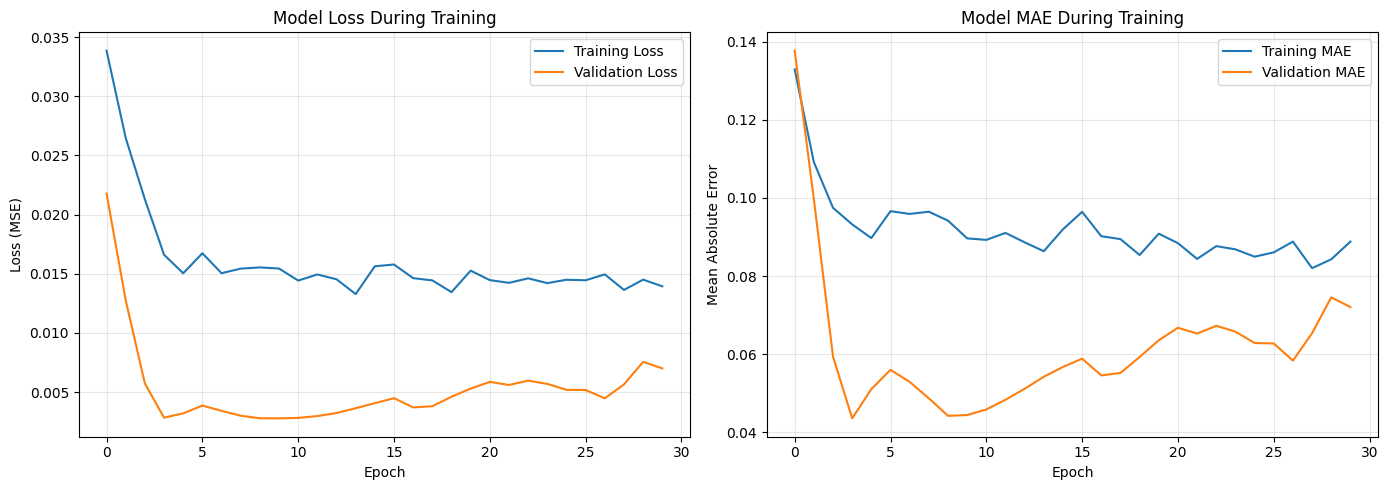

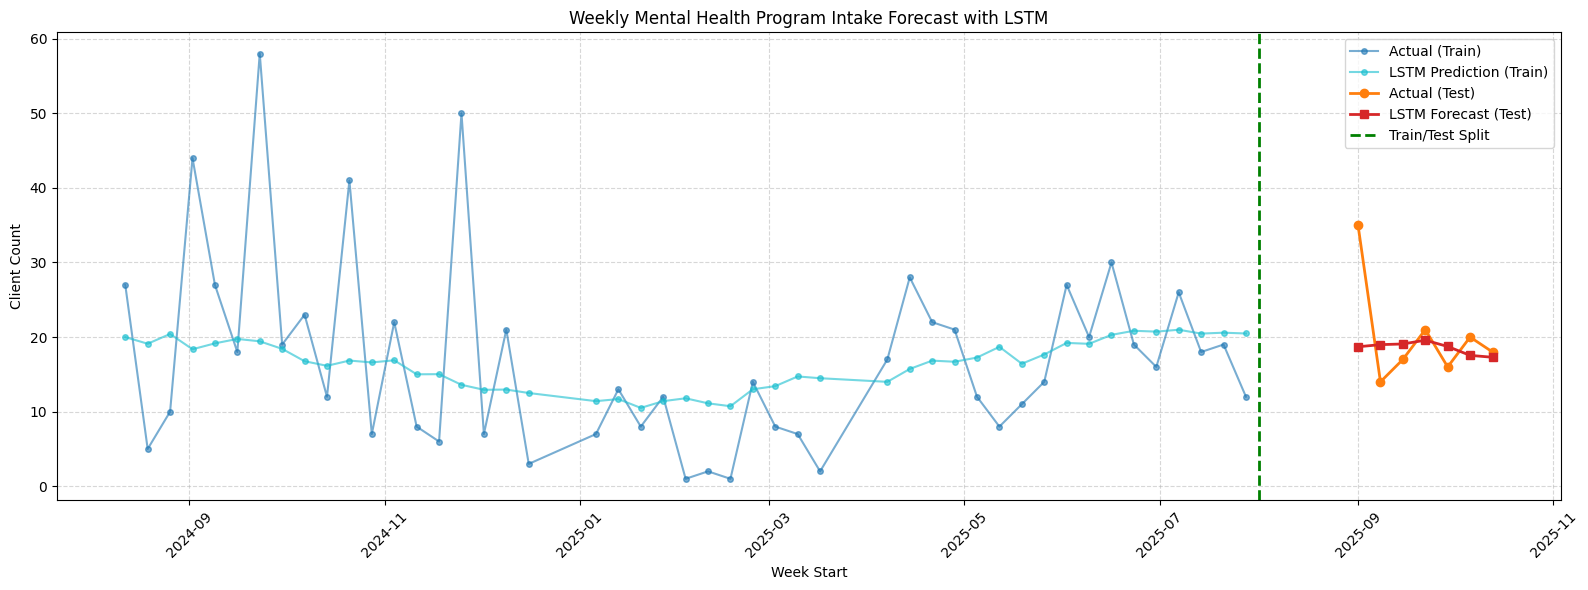

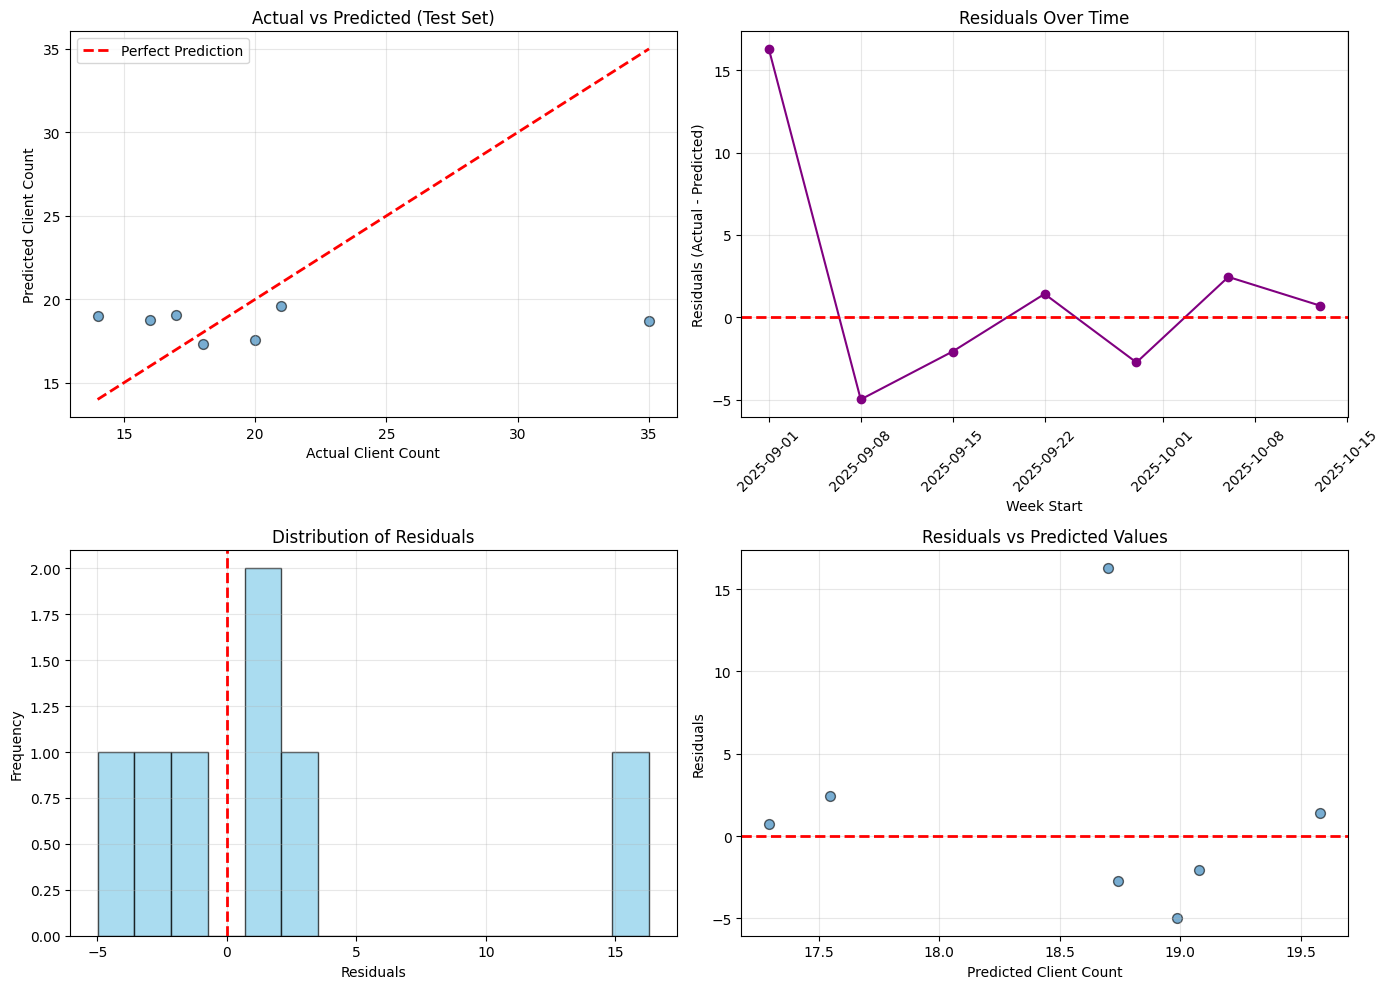


PREDICTION DETAILS
        Week  Actual  Predicted  Residual  Abs Error  % Error
0 2025-09-01    35.0  18.700001     16.30      16.30    46.57
1 2025-09-08    14.0  18.990000     -4.99       4.99    35.62
2 2025-09-15    17.0  19.080000     -2.08       2.08    12.21
3 2025-09-22    21.0  19.580000      1.42       1.42     6.76
4 2025-09-29    16.0  18.740000     -2.74       2.74    17.12
5 2025-10-06    20.0  17.549999      2.45       2.45    12.26
6 2025-10-13    18.0  17.290001      0.71       0.71     3.92

Worst prediction: 16.3 clients off
Best prediction:  0.7 clients off


In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Prepare dataset ---
df_lstm = merged_df[['week_start_x', 'client_count', 'Mean Temp (°C)']].copy()
df_lstm = df_lstm.dropna()
df_lstm = df_lstm.sort_values('week_start_x').reset_index(drop=True)

print(f"Total data points: {len(df_lstm)}")

# --- Train-test split ---
train = df_lstm[df_lstm['week_start_x'] < '2025-08-01'].copy().reset_index(drop=True)
test = df_lstm[df_lstm['week_start_x'] >= '2025-08-01'].copy().reset_index(drop=True)

print(f"Training set: {len(train)} weeks")
print(f"Test set: {len(test)} weeks")

# --- Scale the data (LSTM works better with normalized data) ---
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_X = MinMaxScaler(feature_range=(0, 1))

# Scale training data
train_y_scaled = scaler_y.fit_transform(train[['client_count']])
train_X_scaled = scaler_X.fit_transform(train[['Mean Temp (°C)']])

# Scale test data
test_y_scaled = scaler_y.transform(test[['client_count']])
test_X_scaled = scaler_X.transform(test[['Mean Temp (°C)']])

# --- Create sequences for LSTM ---
def create_sequences(y_data, X_data, lookback=4):
    """
    Create sequences for LSTM training
    lookback: number of previous time steps to use for prediction
    """
    X_seq, y_seq, X_exog = [], [], []
    
    for i in range(lookback, len(y_data)):
        # Previous 'lookback' weeks of client counts
        X_seq.append(y_data[i-lookback:i, 0])
        # Current week's exogenous variable (temperature)
        X_exog.append(X_data[i, 0])
        # Target: current week's client count
        y_seq.append(y_data[i, 0])
    
    return np.array(X_seq), np.array(X_exog), np.array(y_seq)

# Set lookback period (number of previous weeks to consider)
lookback = 4  # Use past 4 weeks to predict next week

# Create sequences for training
X_train_seq, X_train_exog, y_train_seq = create_sequences(
    train_y_scaled, train_X_scaled, lookback
)

# Create sequences for testing
X_test_seq, X_test_exog, y_test_seq = create_sequences(
    test_y_scaled, test_X_scaled, lookback
)

# Reshape for LSTM input: [samples, timesteps, features]
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], 1))

# Combine sequential and exogenous features
X_train_combined = np.concatenate([
    X_train_seq, 
    X_train_exog.reshape(-1, 1, 1).repeat(lookback, axis=1)
], axis=2)

X_test_combined = np.concatenate([
    X_test_seq, 
    X_test_exog.reshape(-1, 1, 1).repeat(lookback, axis=1)
], axis=2)

print(f"\nTraining sequences shape: {X_train_combined.shape}")
print(f"Test sequences shape: {X_test_combined.shape}")

# --- Build LSTM Model ---
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, 
         input_shape=(lookback, 2)),  # 2 features: client_count + temp
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model summary
print("\n" + "="*50)
print("LSTM MODEL ARCHITECTURE")
print("="*50)
model.summary()

# --- Train the model ---
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

print("\n" + "="*50)
print("TRAINING MODEL...")
print("="*50)

history = model.fit(
    X_train_combined, y_train_seq,
    epochs=200,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- Make predictions ---
train_predict = model.predict(X_train_combined)
test_predict = model.predict(X_test_combined)

# Inverse transform to get actual values
train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)
y_train_actual = scaler_y.inverse_transform(y_train_seq.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

# --- Evaluation Metrics ---
train_mae = mean_absolute_error(y_train_actual, train_predict)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
train_r2 = r2_score(y_train_actual, train_predict)

test_mae = mean_absolute_error(y_test_actual, test_predict)
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
test_r2 = r2_score(y_test_actual, test_predict)
test_mape = np.mean(np.abs((y_test_actual - test_predict) / y_test_actual)) * 100

print("\n" + "="*50)
print("MODEL ACCURACY METRICS")
print("="*50)
print("\nTRAINING SET:")
print(f"MAE:   {train_mae:.2f} clients")
print(f"RMSE:  {train_rmse:.2f} clients")
print(f"R²:    {train_r2:.4f}")

print("\nTEST SET:")
print(f"MAE:   {test_mae:.2f} clients")
print(f"RMSE:  {test_rmse:.2f} clients")
print(f"MAPE:  {test_mape:.2f}%")
print(f"R²:    {test_r2:.4f}")
print("="*50)

# Interpretation
print("\nINTERPRETATION:")
print(f"- On average, predictions are off by {test_mae:.1f} clients")
print(f"- The model explains {test_r2*100:.1f}% of variance in client count")
if test_mape < 10:
    print(f"- MAPE of {test_mape:.1f}% indicates EXCELLENT accuracy")
elif test_mape < 20:
    print(f"- MAPE of {test_mape:.1f}% indicates GOOD accuracy")
elif test_mape < 30:
    print(f"- MAPE of {test_mape:.1f}% indicates REASONABLE accuracy")
else:
    print(f"- MAPE of {test_mape:.1f}% indicates POOR accuracy")

# --- Plot Training History ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss During Training')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Model MAE During Training')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Plot Predictions ---
plt.figure(figsize=(16, 6))

# Get the dates for plotting (accounting for lookback)
train_dates = train['week_start_x'].iloc[lookback:].values
test_dates = test['week_start_x'].iloc[lookback:].values

plt.plot(train_dates, y_train_actual, marker='o', 
         label='Actual (Train)', color='tab:blue', alpha=0.6, markersize=4)
plt.plot(train_dates, train_predict, marker='o', 
         label='LSTM Prediction (Train)', color='tab:cyan', alpha=0.6, markersize=4)
plt.plot(test_dates, y_test_actual, marker='o', 
         label='Actual (Test)', color='tab:orange', linewidth=2, markersize=6)
plt.plot(test_dates, test_predict, marker='s', 
         label='LSTM Forecast (Test)', color='tab:red', linewidth=2, markersize=6)

plt.axvline(x=pd.to_datetime('2025-08-01'), color='green', 
            linestyle='--', linewidth=2, label='Train/Test Split')
plt.xlabel('Week Start')
plt.ylabel('Client Count')
plt.title('Weekly Mental Health Program Intake Forecast with LSTM')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Residual Analysis ---
residuals = y_test_actual.flatten() - test_predict.flatten()

plt.figure(figsize=(14, 10))

# 1. Actual vs Predicted
plt.subplot(2, 2, 1)
plt.scatter(y_test_actual, test_predict, alpha=0.6, edgecolors='k', s=50)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Client Count')
plt.ylabel('Predicted Client Count')
plt.title('Actual vs Predicted (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Residuals over time
plt.subplot(2, 2, 2)
plt.plot(test_dates, residuals, marker='o', linestyle='-', color='purple')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Week Start')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Over Time')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 3. Residuals distribution
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=15, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

# 4. Residuals vs Predicted
plt.subplot(2, 2, 4)
plt.scatter(test_predict, residuals, alpha=0.6, edgecolors='k', s=50)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Client Count')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Prediction Summary Table ---
summary_df = pd.DataFrame({
    'Week': test_dates,
    'Actual': y_test_actual.flatten(),
    'Predicted': test_predict.flatten(),
    'Residual': residuals,
    'Abs Error': np.abs(residuals),
    '% Error': np.abs(residuals / y_test_actual.flatten()) * 100
})

print("\n" + "="*50)
print("PREDICTION DETAILS")
print("="*50)
print(summary_df.round(2))
print(f"\nWorst prediction: {summary_df['Abs Error'].max():.1f} clients off")
print(f"Best prediction:  {summary_df['Abs Error'].min():.1f} clients off")

# --- Save the model (optional) ---
# model.save('lstm_mental_health_forecast.h5')
# print("\nModel saved as 'lstm_mental_health_forecast.h5'")